In [56]:
import immrax as irx
from immrax.embedding import AuxVarEmbedding
from immrax.utils import run_times, gen_ics

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [57]:
class Ex3(irx.System):
    def __init__(self):
        self.xlen = 6
        self.evolution = "continuous"

    def f(self, t: float, x: jax.Array, k: jax.Array) -> jax.Array:
        xA, xF, xFA, xAp, xR, xRAp = x.ravel()
        k1, k2, k3, k4, k5, k6 = k.ravel()
        return jnp.array(
            [
                -k1 * xA * xF + k2 * xFA + k6 * xRAp,
                -k1 * xA * xF + k2 * xFA + k3 * xFA,
                k1 * xA * xF - k2 * xFA - k3 * xFA,
                k3 * xFA - k4 * xAp * xR + k5 * xRAp,
                -k4 * xAp * xR + k5 * xRAp + k6 * xRAp,
                k4 * xAp * xR - k5 * xRAp - k6 * xRAp,
            ]
        )


# Initial conditions
t0, tf = 0, 0.04
dt = 1e-3
x0 = jnp.array([34.0, 20, 0, 0, 16, 0])
k_hat = jnp.array([0.1, 0.033, 16, 5, 0.5, 0.3])
k = irx.interval(k_hat, 10 * k_hat)
x0_int = irx.interval(x0)

# His recommended aux vars
M = jnp.array(
    [
        [-0.48, -0.14, -0.62, -0.48, 0.24, -0.24],
        [-0.31, 0.75, 0.43, -0.31, 0.15, -0.15],
        [0, 0, 0, 0, 0.70, 0.70],
    ]
)
M4 = jnp.array([[-1, 1, 0, 0, 0, 0]])  # Added in example 4
aux_vars = jnp.vstack([M, M4])
H = jnp.vstack([jnp.eye(6), aux_vars])

First, we use *lifting* and *embedding* to compute bounds on the state trajectory in every variable. 

In [58]:
sys = Ex3()
invariants = jnp.zeros(H.shape[0], dtype=bool).at[sys.xlen : sys.xlen + 3].set(True)
esys = AuxVarEmbedding(sys, H, base_invariants=invariants)

x0_le = irx.i2ut(irx.interval(H) @ x0_int)


def params(t, x):
    return k


inputs = (params,)

esys.compute_trajectory(
    t0,
    dt,
    x0_le,
    inputs,
    dt=dt,
)
print("JIT compiled compute_trajectory")
traj, times = run_times(
    100,
    esys.compute_trajectory,
    t0,
    tf,
    x0_le,
    inputs,
    dt=dt,
)
print(f"Compute trajectory took {times.mean():.4g} ± {times.std():.4g} seconds")

JIT compiled compute_trajectory
Compute trajectory took 0.01586 ± 0.0009506 seconds


Now, we compute monte carlo sample trajectories to estimate the tightness of our bounds.

In [59]:
k_mc = gen_ics(k, 100)


def mc_sample(k):
    coeff = lambda t, x: k
    return sys.compute_trajectory(t0, tf, x0, (coeff,), dt=dt)


trajs_mc = jax.vmap(mc_sample)(k_mc)

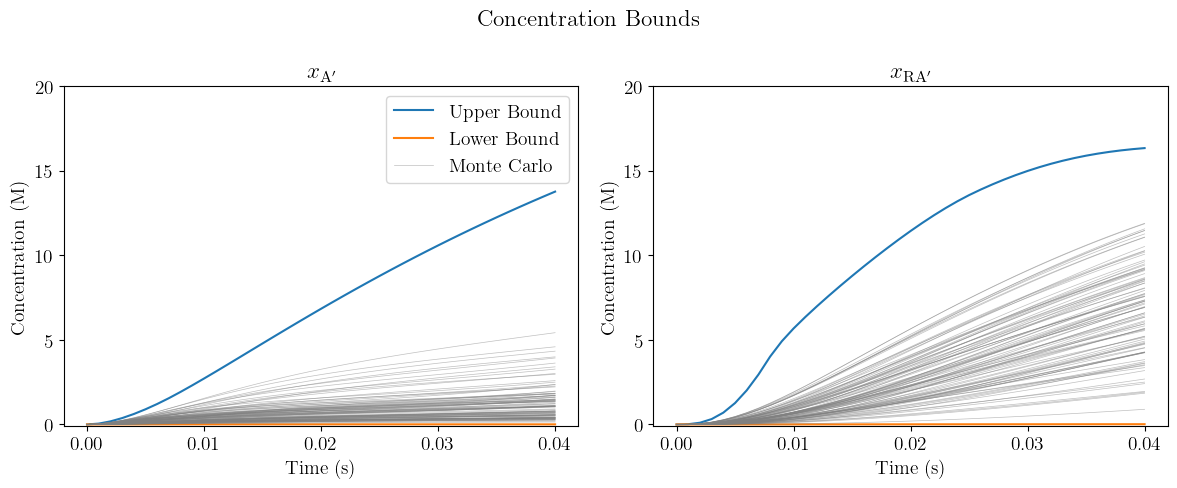

In [60]:
n = len(traj.ys[0]) // 2
lowers = [traj.ys[i][:n] for i in range(len(traj.ts))]
uppers = [traj.ys[i][n:] for i in range(len(traj.ts))]

to_plot = [3, 5]
var_names = [
    "$x_{\\mathrm{A}}$",
    "$x_{\\mathrm{F}}$",
    "$x_{\\mathrm{FA}}$",
    "$x_{\\mathrm{A^\\prime}}$",
    "$x_{\\mathrm{R}}$",
    "$x_{\\mathrm{RA^\\prime}}$",
]

plt.rcParams.update({"text.usetex": True, "font.family": "CMU Serif", "font.size": 14})
fig, axs = plt.subplots(1, len(to_plot), figsize=(6 * len(to_plot), 5))

for i, var in enumerate(to_plot):
    x_lower = [lowers[j][var] for j in range(len(traj.ts))]
    x_upper = [uppers[j][var] for j in range(len(traj.ts))]

    axs[i].plot(traj.ts, x_upper, label="Upper Bound")
    axs[i].plot(traj.ts, x_lower, label="Lower Bound")

    for traj_idx in range(trajs_mc.ts.shape[0]):
        label = "Monte Carlo" if traj_idx == 0 else ""
        axs[i].plot(
            traj.ts,
            [trajs_mc.ys[traj_idx][j][var] for j in range(len(traj.ts))],
            color="gray",
            alpha=0.5,
            linewidth=0.5,
            label=label,
        )

    axs[i].set_title(var_names[var])
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Concentration (M)")
    axs[i].set_ylim([-0.1, 20])
    axs[i].set_yticks(range(0, 21, 5))


axs[0].legend()
fig.suptitle("Concentration Bounds")

plt.tight_layout()
plt.show()

We can demonstrate the invariance of the stoichiometry multiples of the (real) state variables. 
This invariance is precisely what is used to derive the auxiliary state variables described by the $M$ matrix. 

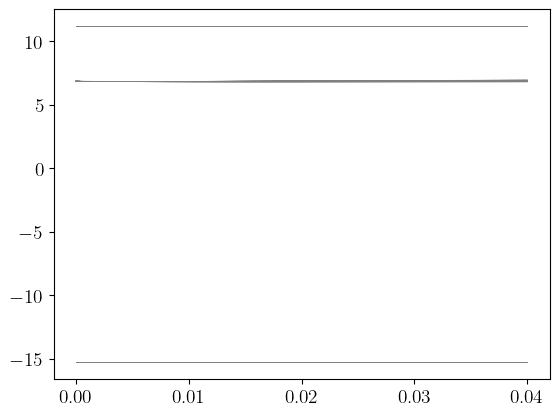

In [62]:
for traj_idx in range(trajs_mc.ts.shape[0]):
    traj = trajs_mc.ys[traj_idx]
    traj_ts = trajs_mc.ts[traj_idx]
    stoich_const = [M @ traj[j][:6] for j in range(len(traj_ts))]
    plt.plot(traj_ts, stoich_const, color="gray", alpha=0.5, linewidth=0.5)